In [1]:
"""
Here we do inference on a DICOM volume, constructing the volume first, and then sending it to the
clinical archive
This code will do the following:
    1. Identify the series to run HippoCrop.AI algorithm on from a folder containing multiple studies
    2. Construct a NumPy volume from a set of DICOM files
    3. Run inference on the constructed volume
    4. Create report from the inference
    5. Call a shell script to push report to the storage archive
"""

import os
import sys
import datetime
import time
import shutil
import subprocess

import numpy as np
import pydicom

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

from inference.UNetInferenceAgent import UNetInferenceAgent

def load_dicom_volume_as_numpy_from_list(dcmlist):
    """Loads a list of PyDicom objects a Numpy array.
    Assumes that only one series is in the array
    Arguments:
        dcmlist {list of PyDicom objects} -- path to directory
    Returns:
        tuple of (3D volume, header of the 1st image)
    """

    # In the real world you would do a lot of validation here
    slices = [np.flip(dcm.pixel_array).T for dcm in sorted(dcmlist, key=lambda dcm: dcm.InstanceNumber)]

    # Make sure that you have correctly constructed the volume from your axial slices!
    hdr = dcmlist[0]

    # We return header so that we can inspect metadata properly.
    # Since for our purposes we are interested in "Series" header, we grab header of the
    # first file (assuming that any instance-specific values will be ighored - common approach)
    # We also zero-out Pixel Data since the users of this function are only interested in metadata
    hdr.PixelData = None
    return (np.stack(slices, 2), hdr)

def get_predicted_volumes(pred):
    """Gets volumes of two hippocampal structures from the predicted array
    Arguments:
        pred {Numpy array} -- array with labels. Assuming 0 is bg, 1 is anterior, 2 is posterior
    Returns:
        A dictionary with respective volumes
    """

    # TASK: Compute the volume of your hippocampal prediction
    print(pred)
    volume_ant = np.sum(pred == 1)
    volume_post = np.sum(pred == 2)
    total_volume = np.sum(pred > 0)

    return {"anterior": volume_ant, "posterior": volume_post, "total": total_volume}

def create_report(inference, header, orig_vol, pred_vol):
    """Generates an image with inference report
    Arguments:
        inference {Dictionary} -- dict containing anterior, posterior and full volume values
        header {PyDicom Dataset} -- DICOM header
        orig_vol {Numpy array} -- original volume
        pred_vol {Numpy array} -- predicted label
    Returns:
        PIL image
    """

    # The code below uses PIL image library to compose an RGB image that will go into the report
    # A standard way of storing measurement data in DICOM archives is creating such report and
    # sending them on as Secondary Capture IODs (http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_A.8.html)
    # Essentially, our report is just a standard RGB image, with some metadata, packed into 
    # DICOM format. 

    pimg = Image.new("RGB", (1000, 1000))
    draw = ImageDraw.Draw(pimg)

    header_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=40)
    main_font = ImageFont.truetype("assets/Roboto-Regular.ttf", size=20)

    slice_nums = [orig_vol.shape[2]//3, orig_vol.shape[2]//2, orig_vol.shape[2]*3//4] # is there a better choice?

    # TASK: Create the report here and show information that you think would be relevant to
    # clinicians. A sample code is provided below, but feel free to use your creative 
    # genius to make if shine. After all, the is the only part of all our machine learning 
    # efforts that will be visible to the world. The usefulness of your computations will largely
    # depend on how you present them.

    # SAMPLE CODE BELOW: UNCOMMENT AND CUSTOMIZE
    draw.text((25, 25), "HippoVolume.AI", (255, 255, 255), font=header_font)
    draw.multiline_text((10, 90),
                        f"Patient ID: {header.PatientID}\n \
                        Study Description: {header.StudyDescription}\n \
                        Series Description: {header.SeriesDescription}\n \
                        Modality: {header.Modality}\n \
                        Image Type: {header.ImageType}\n \
                        Anterior Volume: {inference['anterior']}\n \
                        Posterior Volume: {inference['posterior']}\n \
                        Total Volume: {inference['total']}",
                        (255, 255, 255), font=main_font)

    # STAND-OUT SUGGESTION:
    # In addition to text data in the snippet above, can you show some images?
    # Think, what would be relevant to show? Can you show an overlay of mask on top of original data?
    # Hint: here's one way to convert a numpy array into a PIL image and draw it inside our pimg object:
    #
    # Create a PIL image from array:
    org_slc = orig_vol[0, :, :]
    org_nd_img = np.flip((org_slc/np.max(org_slc))*0xff).T.astype(np.uint8)
    # This is how you create a PIL image from numpy array
    org_pil_i = Image.fromarray(org_nd_img, mode="L").convert("RGBA").resize((250, 250))
    # Paste the PIL image into our main report image object (pimg)
    pimg.paste(org_pil_i, box=(50, 500))

    # Create a PIL image from array:
    # Numpy array needs to flipped, transposed and normalized to a matrix of values in the range of [0..255]
    pred_slc = pred_vol[0, :, :]
    pred_nd_img = np.flip((pred_slc/np.max(pred_slc))*0xff).T.astype(np.uint8)
    # This is how you create a PIL image from numpy array
    pred_pil_i = Image.fromarray(pred_nd_img, mode="L").convert("RGBA").resize((250, 250))
    # Paste the PIL image into our main report image object (pimg)
    pimg.paste(pred_pil_i, box=(550, 500))
    
    return pimg

def save_report_as_dcm(header, report, path):
    """Writes the supplied image as a DICOM Secondary Capture file
    Arguments:
        header {PyDicom Dataset} -- original DICOM file header
        report {PIL image} -- image representing the report
        path {Where to save the report}
    Returns:
        N/A
    """

    # Code below creates a DICOM Secondary Capture instance that will be correctly
    # interpreted by most imaging viewers including our OHIF
    # The code here is complete as it is unlikely that as a data scientist you will 
    # have to dive that deep into generating DICOMs. However, if you still want to understand
    # the subject, there are some suggestions below

    # Set up DICOM metadata fields. Most of them will be the same as original file header
    out = pydicom.Dataset(header)

    out.file_meta = pydicom.Dataset()
    out.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    # STAND OUT SUGGESTION: 
    # If you want to understand better the generation of valid DICOM, remove everything below
    # and try writing your own DICOM generation code from scratch.
    # Refer to this part of the standard to see what are the requirements for the valid
    # Secondary Capture IOD: http://dicom.nema.org/medical/dicom/2019e/output/html/part03.html#sect_A.8
    # The Modules table (A.8-1) contains a list of modules with a notice which ones are mandatory (M)
    # and which ones are conditional (C) and which ones are user-optional (U)
    # Note that we are building an RGB image which would have three 8-bit samples per pixel
    # Also note that writing code that generates valid DICOM has a very calming effect
    # on mind and body :)

    out.is_little_endian = True
    out.is_implicit_VR = False

    # We need to change class to Secondary Capture
    out.SOPClassUID = "1.2.840.10008.5.1.4.1.1.7"
    out.file_meta.MediaStorageSOPClassUID = out.SOPClassUID

    # Our report is a separate image series of one image
    out.SeriesInstanceUID = pydicom.uid.generate_uid()
    out.SOPInstanceUID = pydicom.uid.generate_uid()
    out.file_meta.MediaStorageSOPInstanceUID = out.SOPInstanceUID
    out.Modality = "OT" # Other
    out.SeriesDescription = "HippoVolume.AI"

    out.Rows = report.height
    out.Columns = report.width

    out.ImageType = r"DERIVED\PRIMARY\AXIAL" # We are deriving this image from patient data
    out.SamplesPerPixel = 3 # we are building an RGB image.
    out.PhotometricInterpretation = "RGB"
    out.PlanarConfiguration = 0 # means that bytes encode pixels as R1G1B1R2G2B2... as opposed to R1R2R3...G1G2G3...
    out.BitsAllocated = 8 # we are using 8 bits/pixel
    out.BitsStored = 8
    out.HighBit = 7
    out.PixelRepresentation = 0

    # Set time and date
    dt = datetime.date.today().strftime("%Y%m%d")
    tm = datetime.datetime.now().strftime("%H%M%S")
    out.StudyDate = dt
    out.StudyTime = tm
    out.SeriesDate = dt
    out.SeriesTime = tm

    out.ImagesInAcquisition = 1

    # We empty these since most viewers will then default to auto W/L
    out.WindowCenter = ""
    out.WindowWidth = ""

    # Data imprinted directly into image pixels is called "burned in annotation"
    out.BurnedInAnnotation = "YES"

    out.PixelData = report.tobytes()

    pydicom.filewriter.dcmwrite(path, out, write_like_original=False)

def get_series_for_inference(path):
    """Reads multiple series from one folder and picks the one
    to run inference on.

    Arguments:
        path {string} -- location of the DICOM files

    Returns:
        Numpy array representing the series
    """

    series_path = [dir for dir, subdirs, files in os.walk(path) if 'HCropVolume' in dir]
    chosen_path = np.random.choice(series_path)  
    series_for_inference = [pydicom.dcmread(os.path.join(chosen_path, f)) for f in os.listdir(chosen_path)]

    # Check if there are more than one series (using set comprehension).
    if len({f.SeriesInstanceUID for f in series_for_inference}) != 1:
        print("Error: can not figure out what series to run inference on")
        return []

    return series_for_inference

def os_command(command):
    # Comment this if running under Windows
    sp = subprocess.Popen(["/bin/bash", "-i", "-c", command])
    sp.communicate()

    # Uncomment this if running under Windows
    # os.system(command)


In [2]:
path = './TestVolumes/Study2'
dcmlist = get_series_for_inference(path)
volume, header = load_dicom_volume_as_numpy_from_list(dcmlist)

In [3]:
volume.shape

(36, 48, 35)

In [4]:
header

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 262
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.84632596231518027319301280199914303229
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.54149267487955637153276375735182221723
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.4.0'
(0002, 0016) Source Application Entity Title     AE: 'DicomBrowser'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.84632596231518027319

In [6]:
inference_agent = UNetInferenceAgent(device="cpu",parameter_file_path=r"../../section2/out/model.pth")

In [7]:
pred_label = inference_agent.single_volume_inference_unpadded(np.array(volume))
pred_volumes = get_predicted_volumes(pred_label)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


Creating and pushing report...


/home/nttputus/anaconda3/envs/medai/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide


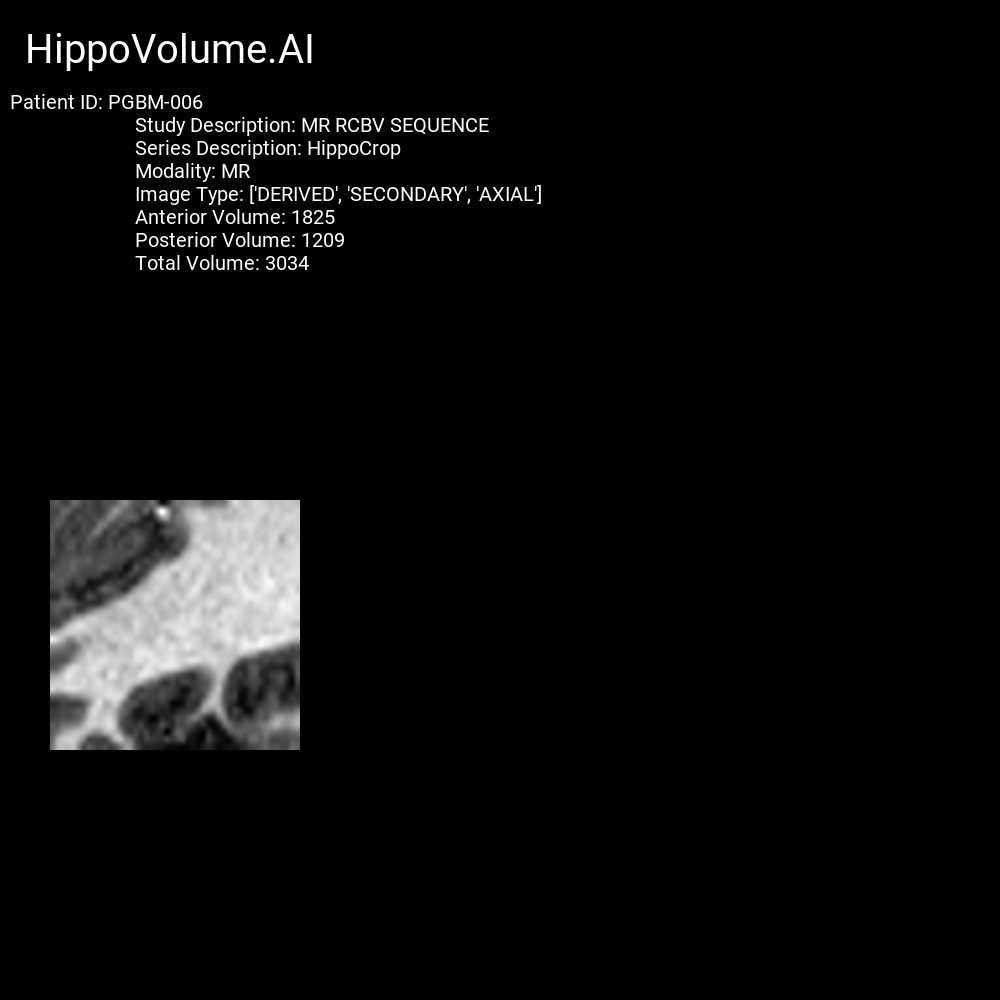

In [8]:
print("Creating and pushing report...")
report_img = create_report(pred_volumes, header, volume, pred_label)
report_img

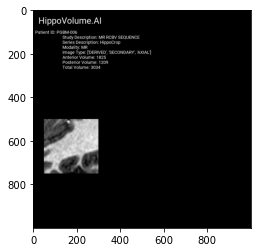

In [9]:
from matplotlib.pyplot import imshow
%matplotlib inline
report_save_path = r"../out/report.dcm"
save_report_as_dcm(header, report_img, report_save_path)
imshow(np.asarray(pydicom.dcmread(report_save_path).pixel_array))